# Calculating the FIM Matrix

This notebook calculates the FIM matrix for a small MLP after learning the toy dataset.

In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import pickle

from utils import mlp,train_test_model
from utils.ewc_utils.ToyExampleEWC import FullEWC

from data.sequential_lines import Lines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
## Get Configurations

n_samples=1000
epochs = 200
lr = 1e-3
batch_size = 100
input_size = 2
hidden_sizes = [128,64]
output_size = 2

seed = 2

num_task = 1

activation='ReLU'
slope=.1
device='cuda:0'

ewc_alpha=0.5

gain={
    'Sigmoid':1.,
    'TanH':1.,
    'ReLU':np.sqrt(2.),
    'leakyReLU':np.sqrt(2./(1.+slope**2))
}

In [58]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):        
        torch.nn.init.xavier_uniform_(m.weight,gain=gain[activation])
        if m.bias: 
            torch.nn.init.xavier_uniform_(m.bias,gain=gain[activation])

In [59]:
## Load Dataset

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
datagen = Lines(max_iter=num_task, num_samples=n_samples)
train_loader,test_loader=datagen.get_sequential_lines(n_task=num_task,batch_size=batch_size)

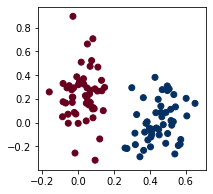

In [60]:
fig,ax =plt.subplots(1,1,figsize=(3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    sample,label=iter_data.next()
    ax.scatter(sample[:,0],sample[:,1],c=label,cmap='RdBu')
# ax.set_xlim([-1.2,1.2])
# ax.set_ylim([-1.2,1.2])
plt.show()

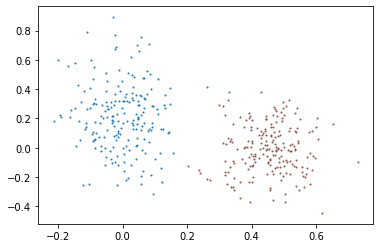

In [61]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure()
for tid in range(num_task):
    for l in range(tid+1):
        idx = np.where(datagen.y == l)
        plt.scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        plt.scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)

In [62]:
X,Y=torch.meshgrid(torch.linspace(-0.5,2.5,150),torch.linspace(-0.75,1.25,100))
grid=torch.stack([X.reshape(-1),Y.reshape(-1)]).T

In [64]:
full_ewc_importance=1e+5

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
full_ewc= FullEWC(model,device=device,alpha=ewc_alpha)

# fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_full_ewc, acc_full_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_full_ewc[task] = []
    acc_full_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_full_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=full_ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=full_ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_full_ewc[sub_task].append(train_test_model.test_classifier(model=full_ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    full_ewc.consolidate(train_loader[task])
    
#     # Plot decision boundary
#     pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
#     ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
#     # Plot data
#     iter_data=iter(train_loader[task])
#     sample,label=iter_data.next()
#     ax[task].scatter(sample[:,0],sample[:,1],c=label,cmap='RdBu')
#     ax[task].set_xlim(-0.5,2.5)
#     ax[task].set_ylim(-0.75,1.25)
#     ax[task].set_title('After Learning Task %d'%task)
# plt.savefig("figure/toy_full_ewc.pdf", bbox_inches='tight')
plt.show()   


In [83]:
B=full_ewc.calculate_FIM(train_loader[task]).to('cpu')
q=np.quantile(abs(B).reshape(-1),np.linspace(0.8,1,10))
print(q)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.17938344e-05
 4.26728046e-04 9.83999576e-04 2.09186994e-03 4.25533205e-03
 9.48998878e-03 2.97599649e+00]


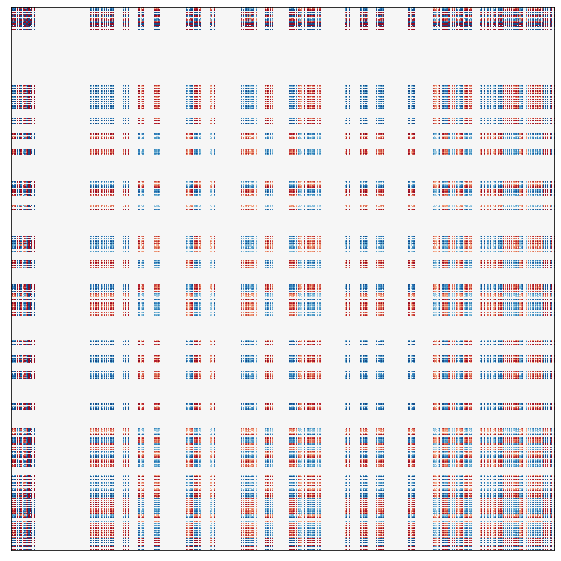

In [80]:
B=full_ewc.calculate_FIM(train_loader[task]).to('cpu')
# vis_thresh=1e-5
# B=np.sign(B)*(abs(B)>vis_thresh)
# B=np.sign(B)*(np.log10((1e-15)+abs(B)))
# B=(np.log10((1e-15)+abs(B)))
# q=np.quantile(abs(B).reshape(-1),np.linspace(0.2,.8,5))
# B=np.argmin(abs(B.reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(B.shape[0],B.shape[1])
q=np.quantile(abs(B).reshape(-1),np.linspace(0.8,1,10))
B=np.sign(B)*np.argmin(abs(abs(B).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(B.shape[0],B.shape[1])
# B=np.argmin(abs(abs(B).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(B.shape[0],B.shape[1])

fig=plt.figure(figsize=(10,10))
osetx=0
osety=osetx
plt.xticks([])
plt.yticks([])
plt.imshow(B[osetx:-1,osety:-1],cmap='RdBu')
plt.savefig("figure/toy_fim_illustration.pdf", bbox_inches='tight')

In [81]:
B=full_ewc.calculate_FIM(train_loader[task]).to('cpu')
print(((B-np.diag(np.diag(B)))**2).sum()/(B**2).sum())
# 2 - 128 - 64 - 2

tensor(0.9882)


In [82]:
print(q)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.17938344e-05
 4.26728007e-04 9.83999576e-04 2.09187018e-03 4.25533159e-03
 9.48998922e-03 2.97599649e+00]


In [ ]:
plt.imshow(B[0:-1,0:-1])

In [10]:
from sklearn.decomposition import TruncatedSVD

In [11]:
svd = TruncatedSVD(n_components=500)
svd.fit(B)
print(svd.singular_values_)

[3.07609058e+03 1.01215259e+03 7.52195190e+02 1.88925507e+02
 1.83034576e+02 1.57248627e+02 1.37237732e+02 8.61974258e+01
 8.58095093e+01 8.50550613e+01 8.23716812e+01 7.52916718e+01
 6.96959915e+01 5.97889481e+01 5.82347069e+01 3.55023994e+01
 3.52324066e+01 3.38083458e+01 3.35622902e+01 2.38126354e+01
 2.37359505e+01 2.00139446e+01 2.00082474e+01 1.90090256e+01
 1.89801426e+01 1.48575163e+01 1.48518877e+01 1.29452791e+01
 1.29384174e+01 1.15179930e+01 1.15177059e+01 1.02936325e+01
 1.02821379e+01 9.44210720e+00 9.43741131e+00 8.92461491e+00
 8.92309761e+00 7.90536785e+00 7.90239382e+00 7.30349445e+00
 7.30291748e+00 6.29345274e+00 6.29242659e+00 6.22012663e+00
 6.21633291e+00 5.99158096e+00 5.98694277e+00 5.80871344e+00
 5.80625820e+00 5.66123009e+00 5.65625620e+00 5.34690428e+00
 5.34649515e+00 4.68140030e+00 4.68138790e+00 4.52787399e+00
 4.52776814e+00 4.34859085e+00 4.34842300e+00 4.29578447e+00
 4.29461670e+00 4.28399706e+00 4.28330660e+00 4.06430960e+00
 4.06429386e+00 3.679116

<BarContainer object of 50 artists>

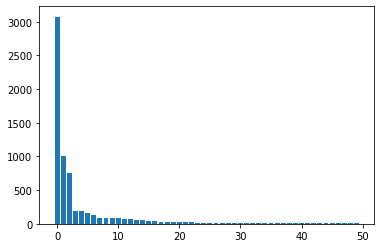

In [12]:
plt.bar(range(len(svd.singular_values_[:50])), svd.singular_values_[:50])